# Skin Lesions: Classification with CNNs

This notebook contains the definition and evaluation of a Convolutional Neural Network (CNN) which aims to classify skin lesion images into three categories:

- [Melanoma](https://es.wikipedia.org/wiki/Melanoma): **malign** cancer, one of the deadliest.
- [Nevus](https://en.wikipedia.org/wiki/Nevus): **benign** skin lesion (mole or birthmark).
- [Seborrheic keratosis](https://en.wikipedia.org/wiki/Seborrheic_keratosis): **benign** skin tumor.

![Skin Disease Classes](https://github.com/mxagar/dermatologist-ai/blob/master/images/skin_disease_classes.png?raw=1)

The project uses the images from the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.isic-archive.com/landing/2017/). Although the challenge is already closed, information on the competition can be obtained from the official [website](https://challenge.isic-archive.com/landing/2017/).

I downloaded the dataset from the following links provided by Udacity to the non-committed folder `data/`, which is subdivided in the train, validation and test subfolders as well as class-name subfolders:

- [training data](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip) (5.3 GB)
- [validation data](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip) (824.5 MB)
- [test data](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip) (5.1 GB)

The images originate from the [ISIC Archive](https://www.isic-archive.com/).

Note that **the present notebook deals with the classification task**; if you are interested in the structure of the dataset, please open the notebook [dataset_structure_visualization.ipynb](./dataset_structure_visualization.ipynb); there, autoencoders are used to find compressed representations of the images.

**Table of Contents**:

- [1. Load Dataset](#1.-Load-Dataset)
    - 1.1 Check Counts
    - 1.2 Visualize some Images
    - 1.3 Define Data Loaders
    - 1.4 Tensor Visualization Function
- [2. Model Definition and Training](#2.-Model-Definition-and-Training)
    - 2.1 Backbone
    - 2.2 Transfer Learning: Classiffier
    - 2.3 Save and Load Functions
    - 2.4 Prediction Function
    - 2.5 Training
- [3. Model Evaluation](#3.-Model-Evaluation)
    - 3.1 Performance with the Test Split
    - 3.2 Evaluation Metrics and Plots
    - 3.3 Save Results
- [4. Conclusions and Notes](#4.-Conclusions-and-Notes)

## 1. Load Dataset

The next cells download the dataset from the links provided above. If you already have a `data/` folder with the images, you don't need to run this.

In [1]:
# https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
# https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
# https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip

!wget -q --show-progress -P data/ https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
!wget -q --show-progress -P data/ https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
!wget -q --show-progress -P data/ https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip

train.zip.1           3%[                    ] 192.46M  94.6MB/s               ^C
valid.zip.1           1%[                    ]   8.67M  41.5MB/s               ^C
test.zip.1            0%[                    ]  30.77M  75.4MB/s               ^C


In [2]:
%%sh
# Unzip the dataset
cd ./data
unzip -q train.zip
unzip -q test.zip
unzip -q valid.zip

In [1]:
# Check GPU info (Google Colab)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct  1 10:52:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1.1 Check Counts

First, let's check how balanced the ddataset is across splits and classes.

In [2]:
import numpy as np
from glob import glob

ROOT_PATH = './data/'

train_melanoma = list(glob(ROOT_PATH+"train/melanoma/*"))
train_nevus = list(glob(ROOT_PATH+"train/nevus/*"))
train_seborrheic = list(glob(ROOT_PATH+"train/seborrheic_keratosis/*"))
train_all = train_melanoma + train_nevus + train_seborrheic

print(f'Train: all: {len(train_all)}')
print(f'Train: melanoma: {len(train_melanoma)}, {100*float(len(train_melanoma))/float(len(train_all))} %')
print(f'Train: nevus: {len(train_nevus)}, {float(100*len(train_nevus))/float(len(train_all))} %')
print(f'Train: seborrheic keratosis: {len(train_seborrheic)}, {100*float(len(train_seborrheic))/float(len(train_all))} %')

test_melanoma = list(glob(ROOT_PATH+"test/melanoma/*"))
test_nevus = list(glob(ROOT_PATH+"test/nevus/*"))
test_seborrheic = list(glob(ROOT_PATH+"test/seborrheic_keratosis/*"))
test_all = test_melanoma + test_nevus + test_seborrheic

print(f'Test: all: {len(test_all)}')
print(f'Test: melanoma: {len(test_melanoma)}, {100*float(len(test_melanoma))/float(len(test_all))} %')
print(f'Test: nevus: {len(test_nevus)}, {float(100*len(test_nevus))/float(len(test_all))} %')
print(f'Test: seborrheic keratosis: {len(test_seborrheic)}, {100*float(len(test_seborrheic))/float(len(test_all))} %')

valid_melanoma = list(glob(ROOT_PATH+"valid/melanoma/*"))
valid_nevus = list(glob(ROOT_PATH+"valid/nevus/*"))
valid_seborrheic = list(glob(ROOT_PATH+"valid/seborrheic_keratosis/*"))
valid_all = valid_melanoma + valid_nevus + valid_seborrheic

print(f'Validation: all: {len(valid_all)}')
print(f'Validation: melanoma: {len(valid_melanoma)}, {100*float(len(valid_melanoma))/float(len(valid_all))} %')
print(f'Validation: nevus: {len(valid_nevus)}, {float(100*len(valid_nevus))/float(len(valid_all))} %')
print(f'Validation: seborrheic keratosis: {len(valid_seborrheic)}, {100*float(len(valid_seborrheic))/float(len(valid_all))} %')

Train: all: 2000
Train: melanoma: 374, 18.7 %
Train: nevus: 1372, 68.6 %
Train: seborrheic keratosis: 254, 12.7 %
Test: all: 600
Test: melanoma: 117, 19.5 %
Test: nevus: 393, 65.5 %
Test: seborrheic keratosis: 90, 15.0 %
Validation: all: 150
Validation: melanoma: 30, 20.0 %
Validation: nevus: 78, 52.0 %
Validation: seborrheic keratosis: 42, 28.0 %


### 1.2 Visualize some Images

Even though I visualize the image with OpenCV here, Pytorch works with PIL images, not numpy arrays; thus, I will need to define another function later on.

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

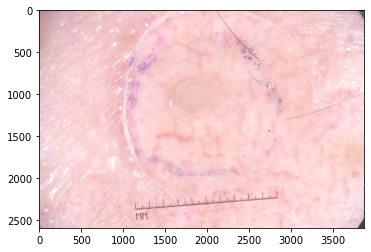

In [4]:
#file = train_melanoma[0]
#file = train_nevus[0]
file = train_seborrheic[0]
img = cv2.imread(file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### 1.3 Define Data Loaders

In [5]:
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision.transforms as transforms
from torchvision import datasets

# When transfer-learning is used we need to adapt our dataset
# to how the pre-trained networks were trained.
# In the case of VGG16/DenseNet/ResNet/Inception,
# they were trained with ImageNet, that means:
# resizing to 224x224 & scaling each channel independently:
# mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
# However, note that if we define our own network and train it, 
# we can use our own size and normalization,
# e.g.: 200x200, mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]

trainpath = ROOT_PATH+'train'
testpath = ROOT_PATH+'test'
validpath = ROOT_PATH+'valid'
batch_size = 64 # 20, 16, 128, 64

# Training data with augmentation (recommended)
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(10),
                                       transforms.Resize(230),
                                       #transforms.CenterCrop(224),
                                       #transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(), # map values to [0,1]
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
# Test data without augmentation
test_transforms = transforms.Compose([ 
                                       transforms.Resize(230),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(), # map values to [0,1]
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

# Validation data without augmentation
valid_transforms = transforms.Compose([
                                       transforms.Resize(230),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(), # map values to [0,1]
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(trainpath, transform=train_transforms)
test_data = datasets.ImageFolder(testpath, transform=test_transforms)
valid_data = datasets.ImageFolder(validpath, transform=valid_transforms)

# IMPORTANT: Set shuffle=False in the TEST data loader creation
# to preserve filename-sample link
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False) # shuffle=False!
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

loaders = {}
loaders['train'] = trainloader
loaders['test'] = testloader
loaders['valid'] = validloader

In [6]:
# We can automatically access the class names
num_classes = len(train_data.classes)
class_names = [item.replace("_", " ") for item in train_data.classes]
print(class_names)

['melanoma', 'nevus', 'seborrheic keratosis']


### 1.4 Tensor Visualization Function

Note that Pytorch images are not loaded as numpy arrays, but as PIL images. Thus I define a simple function that given a PIL image visualizes it.

In [7]:
def visualize(image):
    '''Visualizes one tensor-image'''
    # Convert to numpy and (C,W,H) -> (W,H,C)
    img = image.cpu().numpy().squeeze().transpose((1, 2, 0))
    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * img + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)

Target labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] -> ['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma']


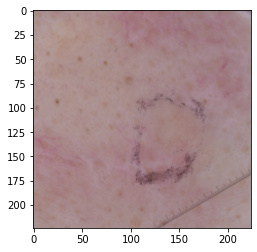

In [8]:
# Take next batch
data_iter = iter(testloader)
images, labels = next(data_iter)

# Print labels
print(f'Target labels: {labels.data.numpy()} -> {[class_names[i] for i in labels.data.numpy()]}')

# Visualize one image from the batch
image = images[0]
visualize(image)

## 2. Model Definition and Training

I will use transfer learning to leverage models that have already been trained on [ImageNet](https://www.image-net.org). [Esteva et al.](https://www.nature.com/articles/nature21056.epdf?author_access_token=8oxIcYWf5UNrNpHsUHd2StRgN0jAjWel9jnR3ZoTv0NXpMHRAJy8Qn10ys2O4tuPakXos4UhQAFZ750CsBNMMsISFHIKinKDMKjShCpHIlYPYUHhNzkn6pSnOCt0Ftf6) report very nice results with a model that uses [Inception-V3](https://en.wikipedia.org/wiki/Inceptionv3) as backbone; however, note that the authors did many things significantly differently compared to me:

- They fine-tuned the model, i.e., they started with the weights of the pre-trained backbone but optimized them for the dataset.
- They worked on the dataset to clean and extend it.
- The problem definition was another one.

Since there seem to be padding issues with the Inception-V3 network, I try the [ResNet50](https://en.wikipedia.org/wiki/Residual_neural_network) network. Residual nets are very good performing architectures, because they avoid the vanishing gradient problem while still allowing very deep models, i.e., with many layers.

### 2.1 Backbone

In [9]:
import torchvision.models as models
import torch.nn as nn

#model = models.inception_v3(pretrained=True)
model = models.resnet50(pretrained=True)
#model = models.densenet121(pretrained=True)
#model = models.vgg16(pretrained=True)

print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 2.2 Transfer Learning: Classiffier

In [10]:
# Check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [11]:
# Freeze parameters of the pre-trained network
# so we don't backprop through them
# ... OR preform fine-tuning of the backbone
for param in model.parameters():
    #param.requires_grad = False # Backbone frozen
    param.requires_grad = True # Fine-tune backbone

# Define our own last classifier layers
# Our inputs must match with the ones
# in the pre-trained network (in_features)
# and REPLACE the model.fc
from collections import OrderedDict
drop_p=0.5
num_classes=3
hidden_nodes_1 = 512 # 500, 256
hidden_nodes_2 = 128
model.fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, hidden_nodes_1)),
                          ('relu1', nn.ReLU()),
                          ('drop1', nn.Dropout(drop_p)),
                          ('fc2', nn.Linear(hidden_nodes_1, hidden_nodes_2)),
                          ('relu2', nn.ReLU()),
                          ('drop2', nn.Dropout(drop_p)),
                          ('fc3', nn.Linear(hidden_nodes_2, num_classes)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# This should not be necessary
for param in model.fc.parameters():
    param.requires_grad = True

if use_cuda:
    model = model.cuda()
    
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# Custom function for weight initialization
# with the Xavier Glorot convention using the normal distribution: 
# Normal(mean=0, std=n), with n = 1 / sqrt(in_nodes)
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        #nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        #nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        #nn.init.kaiming_uniform_(m.weight.data)
        #nn.init.xavier_uniform_(m.weight.data, gain=1.0)
        nn.init.xavier_normal_(m.weight.data, gain=1.0)
        nn.init.constant_(m.bias.data, 0)
    
    return m

# Function that computes the number of trained parameters
# The larger the number, the longer training time
def get_num_parameters(net):
    model_parameters = filter(lambda p: p.requires_grad, net.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [13]:
num_parameters = get_num_parameters(model)
print(f'Number of model parameters to be trained: {num_parameters}')

Number of model parameters to be trained: 24623171


### 2.3 Save and Load Functions

In [14]:
# Custom save & load functions
def save_model(filepath, model):
    torch.save(model.state_dict(), filepath)

def load_checkpoint(filepath, model):
    dev = 'cpu'
    #checkpoint = torch.load(filepath, map_location=torch.device(dev))
    checkpoint = torch.load(filepath, map_location=dev)
    model.load_state_dict(checkpoint)
    return model

In [15]:
filepath = './models/model_0.pt'
save_model(filepath, model)
model = load_checkpoint(filepath, model)

### 2.4 Prediction Function

In [16]:
def predict(img_path, model, use_cuda):
    '''
    Use model to infer skin lesion class given an image
    
    Args:
        img_path: path to an image
        
    Returns:
        Class id
    '''

    # Note: transforms takes PIL formatted images, not numpy arrays
    img = Image.open(img_path) 
    
    # ImageNet dataset requires a specific mean & std normalization
    data_transforms = transforms.Compose([
        transforms.Resize(230),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    # Apply data data transformations and add a dimension for batches
    img_batch = data_transforms(img).unsqueeze(0)

    if use_cuda:
        model = model.cuda()
        img_batch = img_batch.to("cuda", dtype=torch.float)
    
    # Set in evaluation mode! (De-activate dropout, etc.)
    model.eval()
    
    # Predict. Apply softmax to convert logits
    with torch.no_grad():
        # Prediction
        logps = model(img_batch).squeeze(0)
        prediction = torch.exp(logps)
        prediction = prediction.cpu()

    # Class id: index of maximum probability
    class_id = prediction.argmax().item()
    
    return class_id

In [17]:
img_path = train_all[0]
print(img_path)
class_id = predict(img_path, model, use_cuda)
print(class_names[class_id])

./data/train/melanoma/ISIC_0011349.jpg
melanoma


### 2.5 Training

In [18]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # 0.01, 0.003
#optimizer = optim.SGD(model.parameters(), lr=0.001) # 0.01, 0.003

In [19]:
import time

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """Returns trained model"""
    valid_loss_min = np.Inf
    loss_history = {'train': [], 'valid': []}
 
    if use_cuda:
        model = model.cuda()
        
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        num_images_train = 0
        num_images_valid = 0
        
        ###################
        # Train the model #
        ###################
        model.train()

        t1 = time.time()
            
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad() # reset gradients

            logps = model(data) # forward pass
            loss = criterion(logps, target) # compute loss

            loss.backward() # compute gradient / backpropagation
            optimizer.step() # update weights
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #train_loss += loss.item()
            #num_images_train += data.size(0)
            
            if batch_idx%10 == 0:
                #print(f'Epoch: {epoch}, Training Loss: {train_loss/num_images_train:.6f} ')
                print(f'Epoch: {epoch}, Training Loss: {train_loss:.6f} ')
            
        ######################    
        # Validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            with torch.no_grad():
                logps = model(data) # forward pass
                loss = criterion(logps, target) # compute loss
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
                #valid_loss += loss.item()
                #num_images_valid += data.size(0)
        
        #train_loss /= len(loaders['train'].dataset)
        #valid_loss /= len(loaders['valid'].dataset)
        #train_loss /= num_images_train
        #valid_loss /= num_images_valid
        loss_history['train'].append(train_loss.cpu().item())
        loss_history['valid'].append(valid_loss.cpu().item())
        
        t2 = time.time()
        duration = t2-t1
        
        print('-> Epoch: {} \tTrain. Loss: {:.6f} \tVal. Loss: {:.6f} \tDuration: {:.2f} sec.'.format(
            epoch, 
            train_loss,
            valid_loss,
            duration
            ))
        
        if valid_loss < valid_loss_min:
            save_model(save_path, model)
    
    # Return trained model
    return model, loss_history


In [20]:
# Train the model
filepath = './models/model_best.pt'
n_epochs = 50 # 100

#from workspace_utils import active_session
#with active_session():

model, loss = train(n_epochs, loaders, model, optimizer, criterion, use_cuda, filepath)

Epoch: 1, Training Loss: 1.166318 
Epoch: 1, Training Loss: 0.909545 
Epoch: 1, Training Loss: 0.887276 
Epoch: 1, Training Loss: 0.875219 
-> Epoch: 1 	Train. Loss: 0.875916 	Val. Loss: 2.424675 	Duration: 444.77 sec.
Epoch: 2, Training Loss: 0.901673 
Epoch: 2, Training Loss: 0.814521 
Epoch: 2, Training Loss: 0.826669 
Epoch: 2, Training Loss: 0.827935 
-> Epoch: 2 	Train. Loss: 0.829139 	Val. Loss: 1.086322 	Duration: 439.05 sec.
Epoch: 3, Training Loss: 0.752490 
Epoch: 3, Training Loss: 0.831665 
Epoch: 3, Training Loss: 0.799662 
Epoch: 3, Training Loss: 0.803165 
-> Epoch: 3 	Train. Loss: 0.808651 	Val. Loss: 0.955422 	Duration: 438.16 sec.
Epoch: 4, Training Loss: 0.760987 
Epoch: 4, Training Loss: 0.771818 
Epoch: 4, Training Loss: 0.791771 
Epoch: 4, Training Loss: 0.793911 
-> Epoch: 4 	Train. Loss: 0.786868 	Val. Loss: 1.191152 	Duration: 435.77 sec.
Epoch: 5, Training Loss: 0.925525 
Epoch: 5, Training Loss: 0.734611 
Epoch: 5, Training Loss: 0.745022 
Epoch: 5, Training 

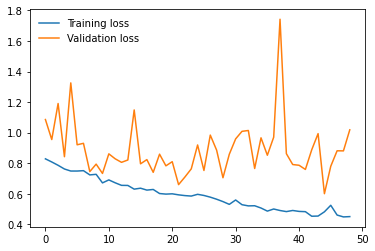

In [21]:
# Plot the loss evolution
from matplotlib import pyplot as plt
plt.plot(loss['train'][1:], label='Training loss')
plt.plot(loss['valid'][1:], label='Validation loss')
plt.legend(frameon=False)

## 3. Evaluation

### 3.1 Performance with the Test Split

In [22]:
# Load the model that got the best validation accuracy
filepath = './models/model_best.pt'
model = load_checkpoint(filepath, model)

In [23]:
import pandas as pd

def test(loaders, model, criterion, use_cuda, batch_size):

    # Monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    # Track samples: filename, y_true, y_pred
    # IMPORTANT: Set shuffle=False in the data loader creation
    # to preserve filename-sample link
    filenames = []
    y_true = []
    y_pred = []
    
    if use_cuda:
        model = model.cuda()
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test'],0):
        # Move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # Get filenames
        for i in range(target.size(0)):
            sample_fname, _ = loaders['test'].dataset.samples[batch_idx*batch_size + i]
            filenames.append(sample_fname)
            #print(sample_fname)
        with torch.no_grad():
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the loss
            loss = criterion(output, target)
        # Update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # Convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # Get y_true, y_pred
        y_pred.extend(list(pred.data.view_as(target).cpu().numpy()))
        y_true.extend(list(target.cpu().numpy()))
        # Compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    # Save results dataframe
    table = {'filename':filenames, 'y_true':y_true, 'y_pred':y_pred }
    df = pd.DataFrame(table)
    
    return df

In [24]:
# Call test function    
df = test(loaders, model, criterion, use_cuda, batch_size)

Test Loss: 0.864766


Test Accuracy: 64% (387/600)


### 3.2 Evaluation Metrics and Plots

#### Save Learning Curves (Plotted Before)

In [25]:
import joblib
joblib.dump(loss, 'models/learning_curves_best.pkl')

['models/learning_curves_best.pkl']

In [26]:
loss = joblib.load('models/learning_curves_best.pkl')

#### Three Classes

In [27]:
y_true = df['y_true']
y_pred = df['y_pred']

In [28]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve

              precision    recall  f1-score   support

           0       0.40      0.56      0.47       117
           1       0.80      0.70      0.75       393
           2       0.49      0.49      0.49        90

    accuracy                           0.65       600
   macro avg       0.56      0.59      0.57       600
weighted avg       0.68      0.65      0.66       600



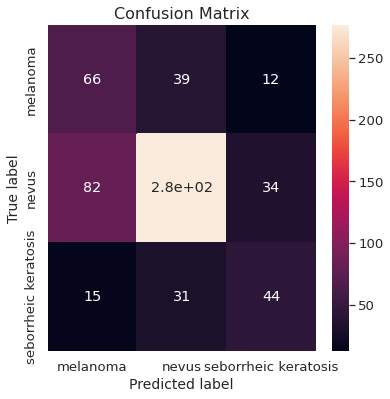

In [30]:
# Confusion matrix; classification report: accuracy, precision, recall, F1
print(classification_report(y_true,y_pred))
plt.figure(figsize=(6,6))
fontsize=14
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label',fontsize=fontsize)
plt.xlabel('Predicted label',fontsize=fontsize)
plt.title('Confusion Matrix',fontsize=fontsize+2)
plt.savefig('./images/confusion_matrix.png',dpi=200,transparent=False,bbox_inches='tight')

#### Cancer vs Non-Cancer / Malign bs Bening

In [31]:
y_true = df['y_true'].replace({0:1, 1:0, 2:0}) # 1 = malign, 0 = bening
y_pred = df['y_pred'].replace({0:1, 1:0, 2:0}) # 1 = malign, 0 = bening

In [32]:
y_true.unique()

array([1, 0])

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       483
           1       0.40      0.56      0.47       117

    accuracy                           0.75       600
   macro avg       0.64      0.68      0.66       600
weighted avg       0.79      0.75      0.77       600



Text(0.5, 9.5, 'Predicted label')

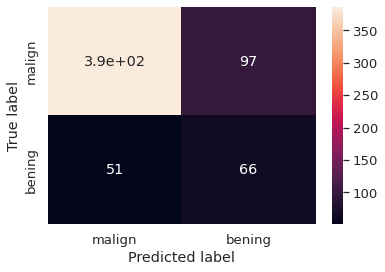

In [33]:
print(classification_report(y_true,y_pred))
sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, xticklabels=['malign', 'bening'], yticklabels=['malign', 'bening'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

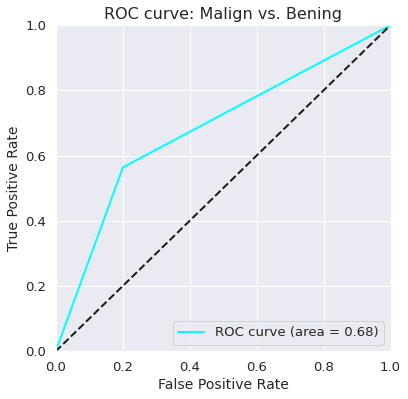

In [34]:
# Compute ROC curve
fpr, tpr, thr = roc_curve(y_true, y_pred)
# Obtain ROC AUC
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='aqua', lw=2,
         label=f'ROC curve (area = {roc_auc:.2f})')

# Format figure
fontsize = 14
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=fontsize)
plt.ylabel('True Positive Rate', fontsize=fontsize)
plt.title('ROC curve: Malign vs. Bening', fontsize=fontsize+2)
plt.legend(loc="lower right")
plt.savefig('./images/roc.png',dpi=200,transparent=False,bbox_inches='tight')

### 3.3 Save Results

In [35]:
df_save = df
df_save['y_true'] = df_save['y_true'].replace({0:class_names[0], 1:class_names[1], 2:class_names[2]})
df_save['y_pred'] = df_save['y_pred'].replace({0:class_names[0], 1:class_names[1], 2:class_names[2]})

In [36]:
# Save to file
save_path = 'results.csv'
df_save.to_csv(save_path, sep=',', header=True, index=False)
df_save = pd.read_csv(save_path)

In [37]:
df_save.head()

,filename,y_true,y_pred
0,./data/test/melanoma/ISIC_0012258.jpg,melanoma,seborrheic keratosis
1,./data/test/melanoma/ISIC_0012356.jpg,melanoma,melanoma
2,./data/test/melanoma/ISIC_0012369.jpg,melanoma,melanoma
3,./data/test/melanoma/ISIC_0012395.jpg,melanoma,melanoma
4,./data/test/melanoma/ISIC_0012425.jpg,melanoma,nevus


In [38]:
# Load and un-transform class names
save_path = 'results.csv'
df = pd.read_csv(save_path)
df['y_true'] = df['y_true'].replace({class_names[0]:0, class_names[1]:1, class_names[2]:2})
df['y_pred'] = df['y_pred'].replace({class_names[0]:0, class_names[1]:1, class_names[2]:2})

### 3.4 Download files from Colab

In [39]:
from google.colab import files

# Best model
files.download('./models/model_best.pt')
# Results
files.download('results.csv')
files.download('./images/confusion_matrix.png')
files.download('./images/roc.png')
files.download('./models/learning_curves_best.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4. Conclusions and Notes

#### V2: Fine-tunes ResNet50 network trained for 50 epochs

- I trained this version on Google Colab Pro with a Tesla T4 for 4-5 hours (50 epochs)
- The results are better with this version, but overall, the model still doesn't work:
    - Melanoma and seborrheic keratosis are often predicted as other skin lesions.
- Accuracy has decreased to 68%, but the recall is better now: 0.56 for the malign case.
- Learning curves:
    - Training loss decreases too slow
    - Validation loss is noisy but it oscillates around the same average
    - Interpretation
        - Probably, we have a large variance error (overfitting)?
        - The learning rate should be increased?
- Next steps:
    - Try with a learning rate scheduler
    - Remove one fully connected layer in the classifier

#### V1: Frozen ResNet50 network trained for 20 epochs

- Overall, the model doesn't work:
    - Most of the melanoma cases are predicted as other types of skin lesions.
    - Seborrheic keratosis is often predicted as nevus.
- The accuracy metric is really bad for such inbalanced classification problems; even though it is 70%, the recall for the malign vs. bening case is 0.07.
- Similarly as Esteva et al. did, I should fine tune the backbone, i.e., the weights of the backbone should be optimized for the dataset, too.